### Import Modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from neupy.estimators import mse
from statsmodels.tsa.stattools import adfuller
from test_stationarity import test_stationarity
from neupy.estimators import mse
from datetime import date
import datetime
from dateutil.relativedelta import relativedelta

In [2]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(window=12,center=False).mean()
#     rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(8, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [3]:
datasets = pd.read_excel('TB_nation.xlsx',index_col='Date')
datasets = datasets[datasets.index > '2004-12-01']

### Exploratory analysis

In [4]:
print("Mean is:",np.mean(datasets.Incidence_rate),"Total Number:",np.sum(datasets.Incidence))

Mean is: 6.58067217528 Total Number: 10487265


### Data Split

In [5]:
datasets_pred = datasets[datasets.index >= '2013-01-1']
datasets = datasets[datasets.index < '2013-01-01']

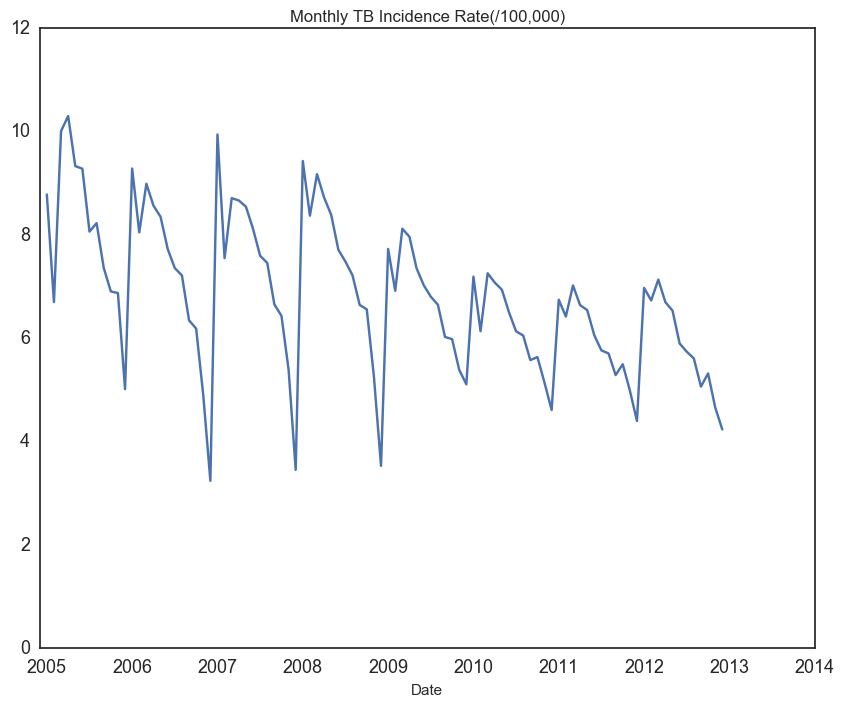

In [6]:
datasets.Incidence_rate.plot(figsize=(10,8), title= 'Monthly TB Incidence Rate(/100,000)',fontsize=13,ylim=(0,12),xlim=('2004-12','2014-01'))
# plt.savefig('month_TB.png',dpi=600)

### Difference

In [7]:
datasets['first_diff'] = datasets.Incidence_rate - datasets.Incidence_rate.shift(1)
datasets['seasonal_difference'] = datasets.Incidence_rate - datasets.Incidence_rate.shift(12)
datasets['seasonal_first_difference'] = datasets.first_diff-datasets.first_diff.shift(12)

### Test of stationarity

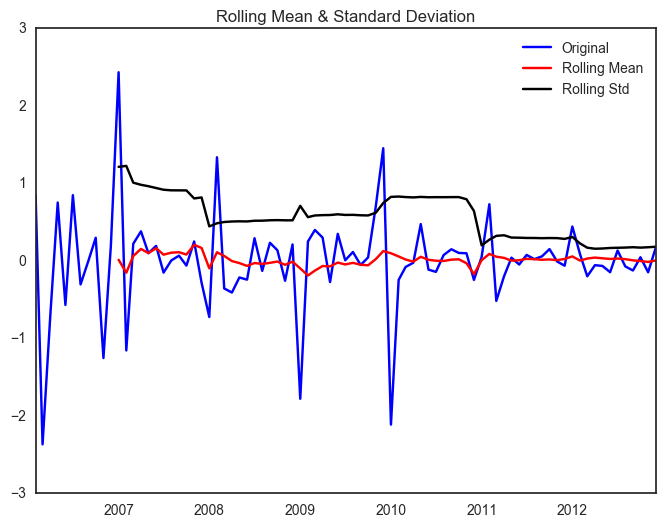

Results of Dickey-Fuller Test:
Test Statistic                -1.018956e+01
p-value                        6.375189e-18
#Lags Used                     1.000000e+00
Number of Observations Used    8.100000e+01
Critical Value (1%)           -3.513790e+00
Critical Value (10%)          -2.586191e+00
Critical Value (5%)           -2.897943e+00
dtype: float64


In [8]:
test_stationarity(datasets.seasonal_first_difference.dropna(inplace=False))

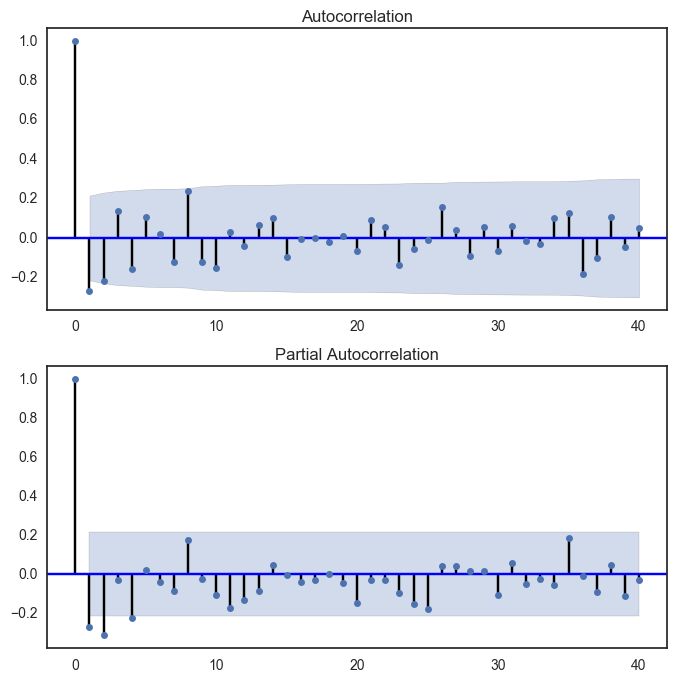

In [9]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.seasonal_first_difference.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.seasonal_first_difference.iloc[13:],lags=40, ax=ax2)
# fig.savefig('ARIMA.png',dpi=600)

def model_selection(p,q,r):
    mod = sm.tsa.SARIMAX(datasets.Incidence_rate, trend='n', order=(p,1,q), seasonal_order=(r,1,0,12))
    results = mod.fit()
    print(results.pvalues)

In [10]:
# def model_selection(p,q,r):
#     mod = sm.tsa.SARIMAX(datasets.Incidence_rate, trend='n', order=(p,1,q), seasonal_order=(r,1,0,12))
#     results = mod.fit()
#     print(results.pvalues)

In [11]:
# for p in range(0,3):
#     for q in range(0,3):
#         for r in range(0,3):
#             if p + q + r ==0 : continue
#             model_selection(p,q,r)
#             print(p,q,r)
#             print('----')

In [12]:
dta = pd.concat([datasets, datasets_pred])[['Incidence','Incidence_rate','Year','Month']]

### Model Selection

In [13]:
def rmse(y_true,y_pred):
    return mse(y_true,y_pred)**0.5

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)*100)

def testing(data,variables):
    rmse_value = round(rmse(data['Incidence_rate'],data[variables]),4)
    mse_value = round(mse(data['Incidence_rate'],data[variables]),4)
    mape_value = round(mape(data['Incidence_rate'],data[variables]),4)
    return mse_value, rmse_value, mape_value

def model_confirm(data,p,q,P):
    results = sm.tsa.SARIMAX(datasets.Incidence_rate, trend='n', order=(p,1,q), seasonal_order=(P,1,0,12)).fit()
    data['forecast'] = results.predict(start=13,end=131,dynamic=False)
    TB_intro = data[data.index <'2013-01-1']
    TB_Evidence = data[data.index >='2013-01-1']
    print(testing(TB_intro.dropna(),'forecast'),testing(TB_Evidence,'forecast'),results.aic)

In [14]:
model_confirm(dta,0,1,0)

(0.3486, 0.5904, 5.1695000000000002) (0.1256, 0.3545, 5.0913000000000004) 151.148250717


In [15]:
model_confirm(dta,0,2,0)

(0.3336, 0.5776, 5.2108999999999996) (0.1443, 0.3799, 4.9968000000000004) 146.66029192


In [16]:
model_confirm(dta,1,0,0)

(0.3728, 0.6106, 5.1986999999999997) (0.1264, 0.3555, 5.0655000000000001) 157.589431474


In [17]:
model_confirm(dta,2,0,0)

(0.3409, 0.5839, 5.1153000000000004) (0.1239, 0.352, 5.0830000000000002) 150.48797268


### Model diagnostics

In [18]:
mod = sm.tsa.SARIMAX(datasets.Incidence_rate, trend='n', order=(2,1,0), seasonal_order=(0,1,0,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     Incidence_rate   No. Observations:                   96
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -72.244
Date:                            Sat, 26 Nov 2016   AIC                            150.488
Time:                                    11:27:50   BIC                            158.181
Sample:                                01-01-2005   HQIC                           153.598
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3467      0.077     -4.523      0.000      -0.497      -0.196
ar.L2         -0.3492      0.088   

In [19]:
dta['forecast'] = results.predict(start=13,end=131,dynamic=False)

In [20]:
dta['error_ARIMA'] = dta['Incidence_rate']-dta['forecast']

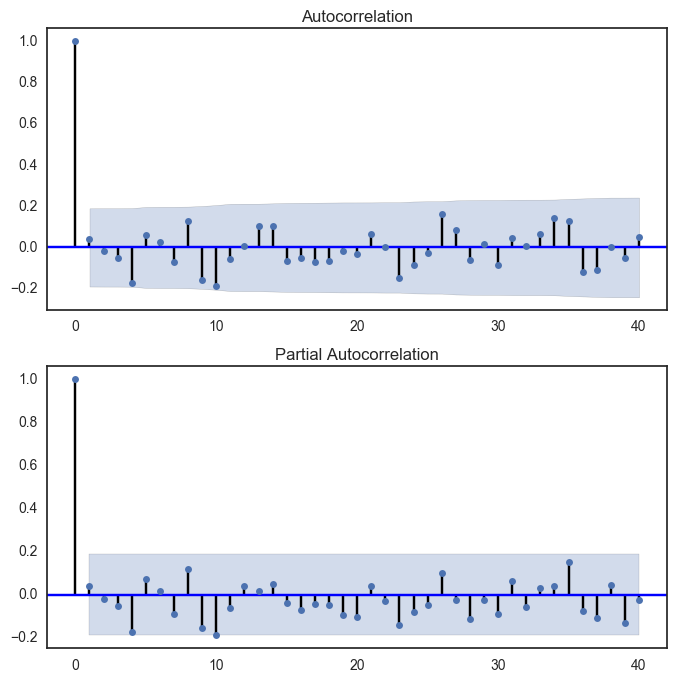

In [21]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.error_ARIMA.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta.error_ARIMA.iloc[13:],lags=40, ax=ax2)
# fig.savefig('Error_ARIMA.png',dpi=600)

### Time series of forecasting

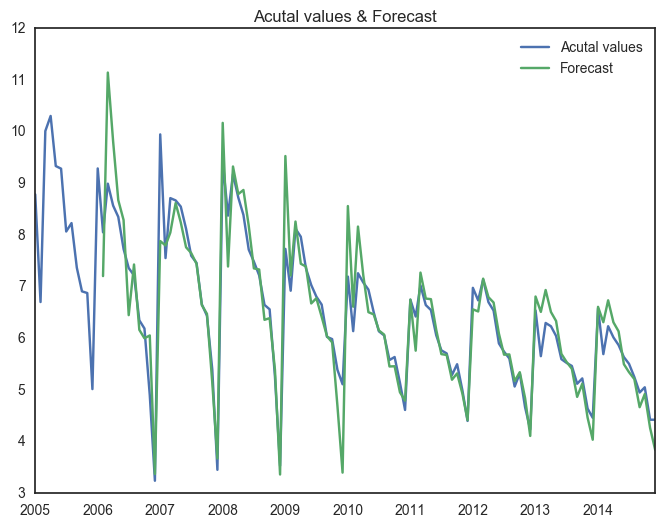

In [22]:
fig = plt.figure(figsize=(8, 6))
plt.plot(dta.Incidence_rate,label='Acutal values')
plt.plot(dta.forecast, label='Forecast')
plt.legend(loc='best')
plt.title('Acutal values & Forecast')
# fig.savefig('Forecast_Time_Series.png',dpi=600)

In [23]:
start = datetime.datetime.strptime("2015-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,132)]
future = pd.DataFrame(index=date_list, columns= dta.columns)
TB_future = pd.concat([dta,future])

In [24]:
TB_future['forecast'] = results.predict(start = 13, end = 263, dynamic= False)
TB_future['Year'] = TB_future.index.year
TB_future[['forecast','Incidence_rate','Year']].groupby('Year').apply(lambda x:np.sum(x))[['forecast','Incidence_rate']]

,forecast,Incidence_rate
Year,,
2005,NaN,96.878875
2006,80.584918,86.234749
2007,85.370020,88.549250
2008,88.908595,88.515012
2009,79.749047,81.093508
2010,76.398733,74.272892
2011,70.699142,71.091647
2012,70.646558,70.620700
2013,68.234751,66.795220


In [25]:
TB_year = TB_future[['forecast','Incidence_rate','Year']].groupby('Year').apply(lambda x:np.sum(x))[['forecast','Incidence_rate']]

## Grey Model

In [26]:
#-*- coding: utf-8 -*-

import os
os.chdir('/Users/Evan/DataScience/TB_GM/')
files = os.listdir()

from GM11 import GM11

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

In [27]:
inputfile = './data/nation_TB1.csv'
nation = pd.read_csv(inputfile)[['incidence rate']]
nation.index=range(2005,2015)

In [28]:
for k in range(2015,2026):
    nation.loc[k] = None

nation['incidence_rate'] = None

for k in range(2005,2026):
    f = GM11(nation['incidence rate'].loc[range(2005,2015)].as_matrix())
    nation['incidence_rate'].loc[k] = f[0](k-2005+1).round(2)
nation

/Users/Evan/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,incidence rate,incidence_rate
2005,96.878875,94.29
2006,86.234749,90.44
2007,88.549250,86.74
2008,88.515012,83.19
2009,81.093508,79.79
2010,74.272892,76.53
2011,71.091647,73.4
2012,70.620700,70.4
2013,66.795220,67.52
2014,65.628808,64.76


In [29]:
data = nation.join(TB_year,how='outer')
data['error_ARIMA']= data['forecast'] - data['incidence rate']
data['error_GM']= data['incidence_rate'] - data['incidence rate']
data['error_GM_rate'] = data['error_GM']/data['incidence rate']*100
data['error_ARIMA_rate'] = data['error_ARIMA']/data['incidence rate']*100

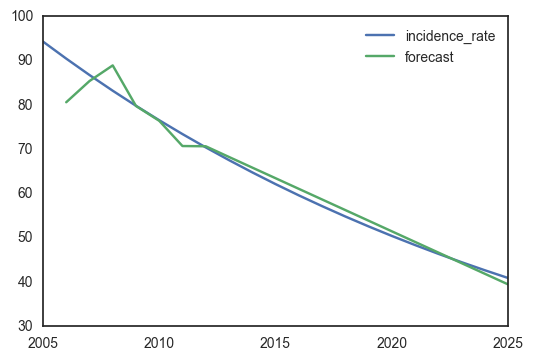

In [30]:
data[['incidence_rate','forecast']].plot()

In [49]:
data.to_excel('data_predict.xlsx')

In [50]:
%pwd

'/Users/Evan/DataScience/TB_GM'

In [31]:
result_final = data[data.index <= 2014]

In [32]:
result_final_2014 = data[(data.index <= 2014) & (data.index >= 2005)]
result_final_2014

,incidence rate,incidence_rate,forecast,Incidence_rate,error_ARIMA,error_GM,error_GM_rate,error_ARIMA_rate
2005,96.878875,94.29,NaN,96.878875,NaN,-2.58888,-2.67228,NaN
2006,86.234749,90.44,80.584918,86.234749,-5.649831,4.20525,4.87652,-6.551687
2007,88.549250,86.74,85.370020,88.549250,-3.179230,-1.80925,-2.04321,-3.590353
2008,88.515012,83.19,88.908595,88.515012,0.393583,-5.32501,-6.01594,0.444651
2009,81.093508,79.79,79.749047,81.093508,-1.344460,-1.30351,-1.60741,-1.657914
2010,74.272892,76.53,76.398733,74.272892,2.125841,2.25711,3.03894,2.862203
2011,71.091647,73.4,70.699142,71.091647,-0.392505,2.30835,3.24701,-0.552111
2012,70.620700,70.4,70.646558,70.620700,0.025858,-0.2207,-0.312515,0.036615
2013,66.795220,67.52,68.234751,66.795220,1.439530,0.72478,1.08508,2.155140
2014,65.628808,64.76,65.837596,65.628808,0.208788,-0.868808,-1.32382,0.318135


In [33]:
np.sum(abs(result_final_2014.error_GM_rate))/10

2.6222728413862626

In [34]:
result_dta = result_final_2014[result_final_2014.index > 2006]
np.sum(abs(result_dta.error_GM_rate))/8

2.3342414737284667

In [35]:
mape(result_final.Incidence_rate, result_final.incidence_rate)
mse(result_final.Incidence_rate, result_final.incidence_rate)
rmse(result_final.Incidence_rate, result_final.incidence_rate)

2.635650928951066

In [36]:
mse(result_final_2014.Incidence_rate, result_final_2014.incidence_rate)
rmse(result_final_2014.Incidence_rate, result_final_2014.incidence_rate)
mape(result_final_2014.Incidence_rate, result_final_2014.incidence_rate)

2.6222728413862608

In [37]:
dta = data[data.index >= 2007]

In [38]:
dta

,incidence rate,incidence_rate,forecast,Incidence_rate,error_ARIMA,error_GM,error_GM_rate,error_ARIMA_rate
2007,88.549250,86.74,85.370020,88.549250,-3.179230,-1.80925,-2.04321,-3.590353
2008,88.515012,83.19,88.908595,88.515012,0.393583,-5.32501,-6.01594,0.444651
2009,81.093508,79.79,79.749047,81.093508,-1.344460,-1.30351,-1.60741,-1.657914
2010,74.272892,76.53,76.398733,74.272892,2.125841,2.25711,3.03894,2.862203
2011,71.091647,73.4,70.699142,71.091647,-0.392505,2.30835,3.24701,-0.552111
2012,70.620700,70.4,70.646558,70.620700,0.025858,-0.2207,-0.312515,0.036615
2013,66.795220,67.52,68.234751,66.795220,1.439530,0.72478,1.08508,2.155140
2014,65.628808,64.76,65.837596,65.628808,0.208788,-0.868808,-1.32382,0.318135
2015,NaN,62.11,63.440436,NaN,NaN,NaN,NaN,NaN
2016,NaN,59.57,61.043275,NaN,NaN,NaN,NaN,NaN


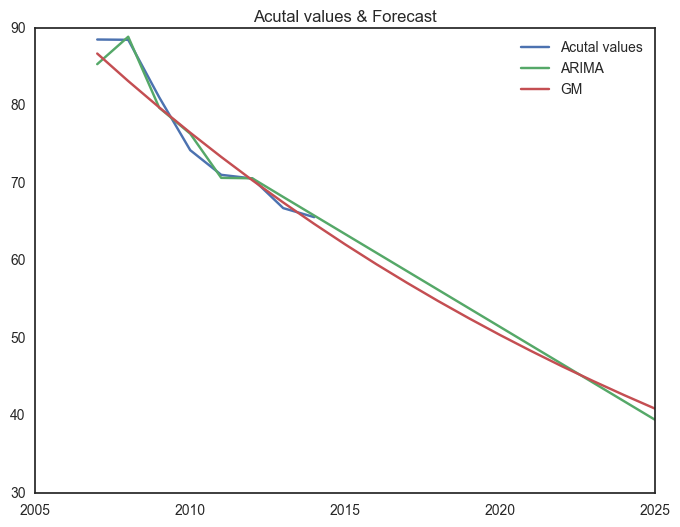

In [39]:
fig = plt.figure(figsize=(8,6))
plt.plot(dta.Incidence_rate,label='Acutal values')
plt.plot(dta.forecast, label='ARIMA')
plt.plot(dta.incidence_rate, label='GM')
plt.legend(loc='best')
plt.title('Acutal values & Forecast')
# fig.savefig('Forecast_Time_Series.png',dpi=600)

In [40]:
data['mean'] = (data['incidence_rate']+data['forecast'])/2

In [41]:
def development_rate(start,end,year):
    return ((end/start)**(1/year)-1)*100

In [42]:
development_rate(data.loc[2005,'incidence rate'],data.loc[2014,'incidence rate'],10)

-3.8196079706591113

In [43]:
development_rate(data.loc[2015,'incidence_rate'],data.loc[2025,'incidence_rate'],11)

-3.7246140718881326

In [44]:
development_rate(data.loc[2015,'forecast'],data.loc[2025,'forecast'],11)

-4.2227078269321154

In [45]:
development_rate(data.loc[2015,'incidence_rate'],data.loc[2020,'incidence_rate'],6)

-3.4188153621007134

In [46]:
development_rate(data.loc[2015,'forecast'],data.loc[2020,'forecast'],6)

-3.4298169380741261

In [47]:
dta.to_excel('/Users/Evan/Desktop/result.xlsx')